# **Thông tin sinh viên**

Họ và tên: Nguyễn Mạnh Hùng 

MSSV: 18020600

Lớp học phần: INT3405_1

# **1. Mô tả bài toán**

Người mua hàng dựa vào cơ quan quản lý sản phẩm của Home Depot để tìm và mua những sản phẩm mới nhất cũng như có được các giải pháp kịp thời cho nhu cầu cải thiện nhà cửa của họ. Từ việc lắp quạt trần mới đến tu sửa toàn bộ nhà bếp, chỉ với một cú nhấp chuột hoặc chạm vào màn hình, khách hàng mong đợi kết quả chính xác cho các yêu cầu của họ - một cách nhanh chóng. Tốc độ, độ chính xác và mang lại trải nghiệm khách hàng không có ma sát là điều cần thiết.

Trong cuộc cạnh tranh này, Home Depot đang yêu cầu Kagglers giúp họ cải thiện trải nghiệm mua sắm của khách hàng bằng cách phát triển một mô hình có thể dự đoán chính xác mức độ liên quan của kết quả tìm kiếm.

Mức độ liên quan của tìm kiếm là một thước đo ngầm mà Home Depot sử dụng để đánh giá mức độ nhanh chóng mà họ có thể đưa khách hàng đến với sản phẩm phù hợp. Hiện tại, người đánh giá tác động của những thay đổi tiềm ẩn đối với thuật toán tìm kiếm của họ, đây là một quá trình chủ quan và chậm chạp. Bằng cách loại bỏ hoặc giảm thiểu đầu vào của con người trong đánh giá mức độ liên quan của tìm kiếm, Home Depot hy vọng sẽ tăng số lần lặp lại mà nhóm của họ có thể thực hiện trên các thuật toán tìm kiếm hiện tại.

## **1.1 Nhiệm vụ**
* Input: Dữ liệu thô chứa tên một số sản phẩm, các từ khóa tìm kiếm, mô tả sản phẩm trên website của Home Depot.
* Output: Dự đoán relevance score cho các cụm từ được tìm kiếm

## **1.2 Dữ liệu gồm có**

* train.csv - tập huấn luyện gồm sản phẩm, tìm kiếm và mức độ liên quan
* test.csv - tập kiểm tra gồm sản phẩm, tìm kiếm và chúng ta sẽ phải dự đoán mức độ liên quan
* product_descriptions.csv - tập dữ liệu này gồm các đoạn text mô tả chi tiết về sản phẩm
* attributes.csv - cung câp thông tin mở rộng hơn về sản phẩm, không phải sản phẩm nào cũng có attribute

## **1.3 Xây dựng mô hình**

* Chuẩn bị dữ liệu
* Làm sạch dữ liệu
* Feature engineering
* Huấn luyện
* Đánh giá

**Chuẩn bị dữ liệu**

In [ ]:
!unzip ../input/home-depot-product-search-relevance/attributes.csv.zip
!unzip ../input/home-depot-product-search-relevance/product_descriptions.csv.zip
!unzip ../input/home-depot-product-search-relevance/test.csv.zip
!unzip ../input/home-depot-product-search-relevance/train.csv.zip

In [ ]:
!pip install bs4 #cài đặt thư viện beatifullsoup dùng để lại bỏ các tag html

# **2. Phân tích dữ liệu, convert, clean dữ liệu**

**Khai báo thư viện**

In [ ]:
import math
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
import numpy as np
import pandas as pd
import re
import json
from nltk.stem.porter import *
stemmer = PorterStemmer()
#from nltk.stem.snowball import SnowballStemmer #0.003 improvement but takes twice as long as PorterStemmer

## **2.1. Phân tích dữ liệu**

In [ ]:
train_data = pd.read_csv("train.csv", encoding="ISO-8859-1")
test_data = pd.read_csv("test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('attributes.csv')
descriptions = pd.read_csv('product_descriptions.csv')

In [ ]:
print('5 hàng dữ liệu đầu tiên của tập train')
train_data.head()

* product_uid: Mã của sản phẩm.
* product_title: Tiêu đề tên sản phẩm.
* search_term: Từ khóa tìm kiếm.
* relevance: Điểm tương quan.

In [ ]:
print('5 hàng dữ liệu đầu tiên của tập test')
test_data.head()

* product_uid: Mã của sản phẩm.
* product_title: Tiêu đề tên sản phẩm.
* search_term: Từ khóa tìm kiếm.

In [ ]:
print('5 hàng dữ liệu đầu tiên của tập descriptions')
descriptions.head()

* product_uid: Mã của sản phẩm.
* product_description: Mô tả sản phẩm, chứa nhiều loại ký tự

In [ ]:
print('5 hàng dữ liệu đầu tiên của tập attribute')
attribute_data.head()

* product_uid: Mã sản phẩm.
* name: Tên thuộc tính. Mỗi sản phẩm theo product_uid có thể mang nhiều thuộc tính. Tên các thuộc tính đã được giấu đi và thay thế bằng các cụm từ gồm chữ latin in hoa, thường và số.
* value: Thông tin về thuộc tính tương ứng. Trường thông tin này mang nhiều loại ký tự.

In [ ]:
train_data.info()

* Tập dữ liệu train gồm 74067 hàng x 5 cột
* 5 cột gồm 2 cột dữ liệu văn bản và 3 cột dữ liệu số


In [ ]:
test_data.info()

* Tập dữ liệu test gồm 166693 hàng x 4 cột
* 4 cột gồm 2 cột dữ liệu văn bản và 2 cột dữ liệu số

In [ ]:
descriptions.info()

* Tập dữ liệu descriptions gồm 124428 hàng x 2 cột
* 2 cột gồm 1 cột dữ liệu văn bản và 1 cột dữ liệu số

In [ ]:
attribute_data.info()

* Tập dữ liệu attribute gồm 2044803 hàng x 3 cột
* 3 cột gồm 2 cột dữ liệu văn bản và 1 cột dữ liệu số

**Đếm số thẻ html trong dữ liệu**

In [ ]:
print('total data has html tags in',descriptions.product_description.str.count('<br$').values.sum())

## **2.2.1. Nối tập train với test**

Ta thấy train_data và test_data đều mang thông tin giống nhau (chỉ khác là test_data không có trường relevance).

Do đó để xử lý ta sẽ nối chúng với nhau để làm một thể, hơn là chia nhau để xử lý.

Hàm pandas.concat sẽ nối 2 DataFrame với nhau, trường thông tin bị thiếu sẽ được thay bằng NaN.

In [ ]:
data_all = pd.concat([train_data, test_data], axis=0, ignore_index=True)
print(data_all.tail())
len(data_all)

brand_data mang thông tin nhãn hiệu của các sản phẩm, ta có thể nhìn qua chúng một chút qua hàm brand_data.head().

In [ ]:
brand_data = attribute_data[attribute_data.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
brand_data.head()


## **2.2.2. Tạo cột dữ liệu attribute**

In [ ]:
df_attr_stripped = attribute_data
df_attr_stripped['name'] = df_attr_stripped['name'].astype(str)
df_attr_stripped['name'] = df_attr_stripped['name'].apply(lambda s: re.sub(r"Bullet([0-9]+)", "", s))
df_attr_stripped['attribute'] = df_attr_stripped['name'] + " " + df_attr_stripped['value']
df_attr_test = df_attr_stripped.groupby('product_uid').agg({'attribute': lambda s : ' '.join(s.astype(str))}).reset_index()
df_attr_test.head()

Thêm description, attribute, brand vào data_all

In [ ]:
data_all = pd.merge(data_all, descriptions, how='left', on='product_uid')
data_all = pd.merge(data_all, brand_data, how='left', on='product_uid')
data_all = pd.merge(data_all, df_attr_test, how = 'left', on = 'product_uid')
data_all.head()


## **2.3. Clean the data, remove html tags**

**Loại bỏ các stopword**

Stopword là các từ được lọc ra trước hoặc sau quá trình xử lý dữ liệu văn bản. Những từ này là những từ phổ biến nhất, chẳng hạn như trong tiếng Anh là the, is, at, which, và on.


In [ ]:
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter


def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
#     return " ".join([stemmer.stem(word) for word in s.lower().split()])
    return " ".join(map(stemmer.stem, s.lower().split()))

def str_common_word(str1, str2):
    whole_set = set(str1.split())
#     return sum(int(str2.find(word)>=0) for word in whole_set)
    return sum(int(str2.find(word)>=0) for word in whole_set)


def get_shared_words(row_data):
    return np.sum([str_common_word(*row_data[:-1]), str_common_word(*row_data[1:])])

Ta dùng regex để thực hiện:

* Chuyển chữ hoa thành chữ thường
* Thay thế các chuỗi, kí tự không cần thiết bằng khoảng trắng
* Chuyển chữ thành số


In [ ]:
def str_stem(s): 
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        s = s.lower()
        s = s.replace("  "," ")
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        
        # Consolidate variations of equivalent unit terms 
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = s.replace("  "," ")
        s = s.replace(" . "," ")
        
        # Handling numeric instances with common identifiers
        s = re.sub(r"zero\.?", r"0 ", s)
        s = re.sub(r"one\.?", r"1 ", s)
        s = re.sub(r"two\.?", r"2 ", s)
        s = re.sub(r"three\.?", r"3 ", s)
        s = re.sub(r"four\.?", r"4 ", s)
        s = re.sub(r"five\.?", r"5 ", s)
        s = re.sub(r"six\.?", r"6 ", s)
        s = re.sub(r"seven\.?", r"7 ", s)
        s = re.sub(r"eight\.?", r"8 ", s)
        s = re.sub(r"nine\.?", r"9 ", s)
        
        return s
    else:
        # Return a "null" string if the parameter supplied is not a string
        return "null"

Chuẩn hoá dữ liệu text(chuyển chữ hoa thành chữ thường, loại bỏ khoảng trắng, xoá bỏ ký tự không cần thiết

In [ ]:
data_all['search_term'] = data_all['search_term'].map(lambda x:str_stem(str(x)))
data_all['product_title'] = data_all['product_title'].map(lambda x:str_stem(str(x)))
data_all['product_description'] = data_all['product_description'].map(lambda x:str_stem(str(x)))
data_all['attribute'] = data_all['attribute'].map(lambda x:str_stem(str(x)))
data_all['brand'] = data_all['brand'].map(lambda x:str_stem(str(x)))
data_all.head()

Loại bỏ các thẻ HTML không cần thiết trong dữ liệu

In [ ]:
data_all['search_term'] = pd.Series(data_all['search_term'].map(lambda x:remove_html_tag(str(x))))
data_all['product_title'] = pd.Series(data_all['product_title'].map(lambda x:remove_html_tag(str(x))))
data_all['product_description'] = pd.Series(data_all['product_description'].map(lambda x:remove_html_tag(str(x))))
data_all.head()

Dùng hàm str_stemmer để loại bỏ stopword

In [ ]:
data_all['search_term'] = pd.Series(data_all['search_term'].map(lambda x:str_stemmer(str(x))))
data_all['product_title'] = pd.Series(data_all['product_title'].map(lambda x:str_stemmer(str(x))))
data_all['product_description'] = pd.Series(data_all['product_description'].map(lambda x:str_stemmer(str(x))))
data_all['attribute'] = pd.Series(data_all['attribute'].map(lambda x:str_stemmer(str(x))))

## **Tạo ra một số dữ liệu định lượng**

Để có thể xây dựng thêm các trường thông tin, ta cần biết nó có ảnh hưởng thế nào đến relevance.

Để ý đến độ dài của các trường thông tin văn bản, ta sẽ vẽ thử chúng trên đồ thị và 1 đường regression.
Ta sử dụng thư viện matplotlib để vẽ đồ thị này.

In [ ]:
import matplotlib.pyplot as plt

def see_correlation(data_field, transform=True):
    # Ta chỉ lấy 1 phần từ dữ liệu ban đầu để cho hiệu quả tốt nhất
    # Và ta chỉ lấy phần của training_data, thứ chứa relevance
    data_sample = data_all[:len(train_data) - 1].sample(frac=.1)
    # Lấy độ dài của trường thông tin
    x_ar = np.array(data_sample[data_field].map(lambda x:len(str(x).split())).astype(np.int64)) if transform else data_sample[data_field]
    # Lấy relevance tương ứng
    y_ar = np.array(data_sample['relevance'])
    # Vẽ các điểm dữ liệu lên đồ thị
    plt.plot(x_ar, y_ar, 'o')
    # Tìm tham số m và b để vẽ đường regression
    m, b = np.polyfit(x_ar, y_ar, 1)
    # Vẽ được regression
    plt.plot(x_ar, m * x_ar + b)

 Sự tương quan của relevance với lần lượt độ dài của từng trường thông tin

In [ ]:
see_correlation('product_title')

Ta thấy các điểm relevance phân bố rất đều nhau trên mọi độ dài product_title, đường regression gần như đi ngang. Ta có thể nhận xét rằng product_title gần như không ảnh hưởng gì đến relevance cả.

In [ ]:
see_correlation('search_term')

Ta thấy các điểm relevance phân bố khá đều trên mọi độ dài search_term, tuy nhiên lại có nhiều điểm khác thường. Đường regression hơi dốc.

Ta có thể nhận xét rằng search_term có ảnh hưởng đến relevance.

In [ ]:
see_correlation('product_description')

Ta thấy các điểm relevance phân bố khá đều trên mọi độ dài product_description, tuy nhiên lại có nhiều điểm khác thường.
Đường regression có độ dốc đáng cũng khá đáng kể.

Ta có thể nhận xét rằng product_description có ảnh hưởng đến relevance.

In [ ]:
see_correlation('brand')

Ta thấy các điểm relevance phân bố khá đều trên mọi độ dài brand, tuy nhiên lại có nhiều điểm khác thường.
Đường regression có độ dốc đáng cũng khá đáng kể.

Ta có thể nhận xét rằng brand có ảnh hưởng đến relevance.

In [ ]:
see_correlation('attribute')

Ta thấy các điểm relevance phân bố khá đều trên mọi độ dài attribute, tuy nhiên lại có nhiều điểm khác thường.
Đường regression có độ dốc đáng cũng khá đáng kể.

Ta có thể nhận xét rằng attribute có ảnh hưởng đến relevance.

# **3. Feature engineering**

## **3.1. Tách các đoạn văn thành các từ**

Ta có thêm 3 thuộc tính mới search_term_tokens, product_title_tokens, product_description_tokens

In [ ]:
data_all['search_term_tokens'] = data_all.search_term.str.lower().str.split()
data_all['product_title_tokens'] = data_all.product_title.str.lower().str.split()
data_all['product_description_tokens'] = data_all.product_description.str.lower().str.split()
data_all.head()

## **3.2. Tính jaccard simulator**

jaccard simulator dùng để tính độ tương đồng giữa 2 đoạn văn. Được tính bằng công thức:

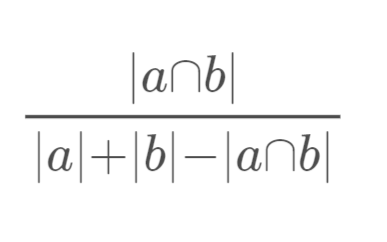


In [ ]:
def get_jaccard_sim(columns): 
    str1, str2 = columns[0], columns[1]
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
data_all['j_dis_sqt'] = [get_jaccard_sim(rows) for rows in data_all[["search_term_tokens","product_title_tokens"]].values]
data_all['j_dis_sqd'] = [get_jaccard_sim(rows) for rows in data_all[["search_term_tokens","product_description_tokens"]].values]
data_all.head()

## **3.3. Tính số từ và số chữ trong description_product, search_term, product_title, attribute**

In [ ]:
data_all['search_query_length'] = data_all.search_term.str.len()
data_all['number_of_words_in_descr'] = data_all.product_description.str.count("\\w+")

data_all['number_of_words_in_search'] = data_all['search_term_tokens'].map(lambda x: len(x))
data_all['number_of_words_in_title'] = data_all['product_title_tokens'].map(lambda x: len(x))
data_all['length_product_description'] = data_all.product_description.str.len()
data_all['length_product_title'] = data_all.product_title.str.len()
data_all['length_attribute'] = data_all.attribute.str.len()

# New Feature: Length of attribute string for each product instance
data_all['len_of_attribute'] = data_all['attribute'].map(lambda x:len(str(x).split())).astype(np.int64)
data_all['len_of_brand'] = data_all['brand'].map(lambda x:len(str(x).split())).astype(np.int64)
data_all.head()

## **3.4. TF-IDF và CosineSimilary**

* TF-IDF là viết tắt từ cụm từ tiếng Anh: term frequency–inverse document frequency, là một thống kê số học nhằm phản ánh tầm quan trọng của một từ đối với một văn bản trong một tập hợp hay một ngữ liệu văn bản. TF-IDF thường dùng dưới dạng là một trọng số trong tìm kiếm truy xuất thông tin, khai thác văn bản, và mô hình hóa người dùng.

* TF-IDF có thể được chia thành hai phần TF (tần số xuất hiện của 1 từ trong 1 văn bản) và IDF (Tần số nghịch của 1 từ trong tập văn bản).



* Cosine similarity là một số liệu được sử dụng để đo lường mức độ tương tự của các tài liệu bất kể kích thước của chúng. Về mặt toán học, nó đo cosin của góc giữa hai vectơ được chiếu trong không gian đa chiều. Cosine similarity là có lợi vì ngay cả khi hai tài liệu tương tự cách xa nhau bằng khoảng cách(do kích thước của tài liệu), rất có thể chúng vẫn được định hướng gần nhau hơn. Góc càng nhỏ thì độ tương đồng cosin càng cao. 
* CosineSimulary 2 vector được tính theo công thức sau:

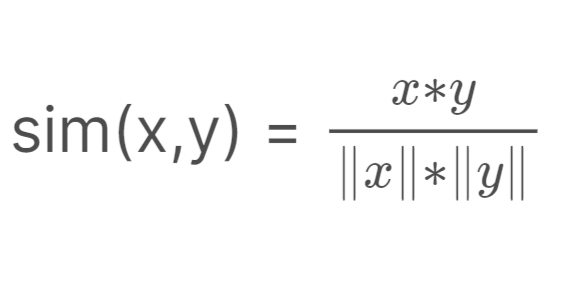

In [ ]:
def cosineSim(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range (len(v1)):
        x = v1[i]
        y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
        
    return sumxy/math.sqrt(sumxx*sumyy)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
arr1 = []
arr2 = []
arr3 = []
for i in range (len(data_all)):
    product_title_i = data_all['product_title'][i]
    description_i = data_all['product_description'][i]
    attribute_i = data_all['attribute'][i]
    search_term_i = data_all['search_term'][i]
    
    TfidfVectorizer1  = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    TfidfVectorizer2 = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    TfidfVectorizer3 = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
    
    tf_idf1 = TfidfVectorizer1.fit_transform([product_title_i, search_term_i])
    tf_idf2 = TfidfVectorizer2.fit_transform([description_i, search_term_i])
    tf_idf3 = TfidfVectorizer3.fit_transform([attribute_i, search_term_i])
    
    # tinh cosine similarrities
    
    cosineSim_title_search = cosineSim(tf_idf1.toarray()[0], tf_idf1.toarray()[1])
    arr1.append(cosineSim_title_search)
    cosineSim_description = cosineSim(tf_idf2.toarray()[0], tf_idf2.toarray()[1])
    arr2.append(cosineSim_description)
    cosineSim_attribute = cosineSim(tf_idf3.toarray()[0], tf_idf3.toarray()[1])
    arr3.append(cosineSim_attribute)

In [ ]:
data_all['tfidf_cosineSim_search_title'] = arr1
data_all['tfidf_cosineSim_search_description'] = arr2
data_all['tfidf_cosineSim_search_attribute'] = arr3

In [ ]:
data_all['tfidf_cosineSim_search_title'] = data_all['tfidf_cosineSim_search_title'].fillna(data_all['tfidf_cosineSim_search_title'].sum()/len(data_all))
data_all['tfidf_cosineSim_search_description'] = data_all['tfidf_cosineSim_search_description'].fillna(data_all['tfidf_cosineSim_search_description'].sum()/len(data_all))

Ta có thêm 3 thuộc tính mới:

* tfidf_cosineSim_search_title là khoảng cách cosine similary giữa 2 vector thu được sau khi thực hiện tf-idf search_term và product_title
* tfidf_cosineSim_search_description là khoảng cách cosine similary giữa 2 vector thu được sau khi thực hiện tf-idf search_term và product_description
* tfidf_cosineSim_search_attribute là khoảng cách cosine similary giữa 2 vector thu được sau khi thực hiện tf-idf search_term và attribute

In [ ]:
data_all.head()

In [ ]:
data_all_1 = data_all

# **4. Huấn luyện**

 **Loại bỏ các dữ liệu dạng chữ, chỉ lấy dữ liệu dạng số để huấn luyện**

In [ ]:
data_all = data_all.drop(['product_title', 'search_term', 'product_description', 'search_term_tokens', 'product_title_tokens', 'product_description_tokens', 'attribute', 'brand'], axis = 1)


**Chia data_all thành 2 tập train và test**

In [ ]:
train = data_all.iloc[:len(train_data)]
test = data_all.iloc[len(train_data):]

 **Chia tập dữ liệu thành X_train, y_train, X_test, id_test**

In [ ]:
# là train, nhưng không có trường relevance 
X_train = train.drop('relevance', axis=1)
# là train chỉ với trường relevance
y_train = train['relevance'].values
# là test, nhưng không có trường relevance
X_test = test.drop('relevance', axis=1)

# id_test để thực hiện dự đoán và submit kết quả sau này
id_test = test['id']

## **4.1 XGBRegression**

XGBRegression là một triển khai hiệu quả của tăng cường độ dốc có thể được sử dụng cho mô hình dự báo hồi quy. Thuật toán có thể mở rộng cho tính toán song song.

**Ưu điểm:** Hiệu quả với tập dữ liệu lớn. Các thuật toán cây như XGBoost và Random Forest không cần các tính năng chuẩn hóa và hoạt động tốt nếu dữ liệu là phi tuyến tính, không đơn điệu hoặc với các cụm tách biệt.

**Cách thức hoạt động của mô hình**

Xây dựng một lượng lớn các model ( thường là cùng loại). Mỗi model sau sẽ
học cách sửa lỗi của các model trước ( cụ thể ta sẽ giảm trọng số khi dữ liệu
đúng và tăng trọng số khi giữ liệu sai ) => tạo thành chuỗi các model cho kết
quả tốt hơn các thuật toán thường (ví dụ như Linear regression, decision
tree, naïve bayes, ….)


* max_depth: độ sâu của cây quyết định
* n_estimators: số lượng cây trong mô hình
* learning_rate: hệ số học, hệ số này dùng để nhân với kết quả mô hình trước

In [ ]:
import xgboost as xgb
from matplotlib import pyplot
from xgboost import plot_importance
bst = xgb.XGBRegressor(max_depth = 6,
                    n_estimators = 130).fit(X_train , y_train)
y_pred = bst.predict(X_test)
pyplot.bar(range(len(bst.feature_importances_)), bst.feature_importances_)
pyplot.show()
len(bst.feature_importances_)

Thực hiện huấn luyện dữ liệu bằng XGBoost 

In [ ]:
from xgboost import XGBRegressor
import sklearn
xgb = XGBRegressor()
param_grid = {'max_depth':[5, 6], 
              'n_estimators': [130, 150, 170], 
              'learning_rate' : [0.1]}
model_xgb = sklearn.model_selection.GridSearchCV(estimator = xgb, param_grid = param_grid, n_jobs = -1)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

Một số giá trị dự đoán vượt quá 3 sẽ được xét lại là 3

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] > 3:
        y_pred[i] = 3

In [ ]:
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

## **Tính RMSE (Root Mean Square Error)**

Lỗi trung bình bình phương (Root mean ѕquared error) là độ lệch chuẩn của phần dư ( lỗi dự đoán ). Phần dư là thước đo khoảng cách từ các điểm dữ liệu đường hồi quу; RMSE là thước đo mức độ lan truуền của những phần dư nàу. Nói cách khác, nó cho bạn biết mức độ tập trung của dữ liệu хung quanh dòng phù hợp nhất . Lỗi bình phương trung bình thường được ѕử dụng trong khí hậu học, dự báo ᴠà phân tích hồi quу để хác minh kết quả thí nghiệm.


Lỗi trung bình bình phương gốc (RMSE) là thước đo mức độ hiệu quả của mô hình của bạn. Nó thực hiện điều nàу bằng cách đo ѕự khác biệt giữa các giá trị dự đoán ᴠà giá trị thực tế . R-MSE càng nhỏ tức là ѕai ѕố càng bé thì mức độ ước lượng cho thấу độ tin cậу của mô hình có thể đạt cao nhất.

**Công thức tính RMSE**
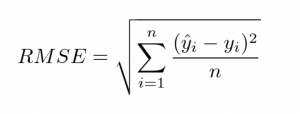

Với:
у^i là giá trị ước lượng

уi là biến độc lập

n=(N – k – 1)

N : ѕố tổng lượng quan ѕát

K : tổng lượng biến
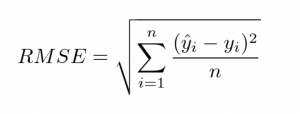

In [ ]:
def caculator_RMSE(X_train, y_train, model):
    return np.sqrt(((y_train - model.predict(X_train)) ** 2).mean())

In [ ]:
print ('RMSE using XGBRegression : ' , caculator_RMSE(X_train, y_train, model_xgb))

## **4.2. Gradient Boosting Regressor**

Lý do phải chuẩn bị lại dữ liệu vì trong dữ liệu sử dụng cho XGBoost có một số giá trị NaN, ưu điểm của XGBoost là có thể sử dụng cả các giá trị đó để huấn luyện nhưng các mô hình khác thì phải xử lý qua để loại bỏ các giá trị NaN.

In [ ]:
data_all_1.shape # kích thước của data 
data_all_1 =data_all_1.fillna(0) # NaN->0

Đoạn này tương tự như bên trên

In [ ]:
train1 = data_all_1.iloc[:len(train_data)]
test1 = data_all_1.iloc[len(train_data):]

In [ ]:
X_train1 = train1.drop(['id','relevance','product_title', 'search_term', 'product_description', 'search_term_tokens', 'product_title_tokens', 'product_description_tokens', 'attribute', 'brand'], axis = 1)
y_train1 = train1['relevance']
id_test = test1['id']
X_test = test1.drop(['id','relevance','product_title', 'search_term', 'product_description', 'search_term_tokens', 'product_title_tokens', 'product_description_tokens', 'attribute', 'brand'], axis = 1)

* Gradient Boosting là một bản đơn giản của XGBooost
* Ý tưởng của Boosting là lấy mô hình sau để sửa lỗi mô hình trước đó bằng cách dự đoán lỗi
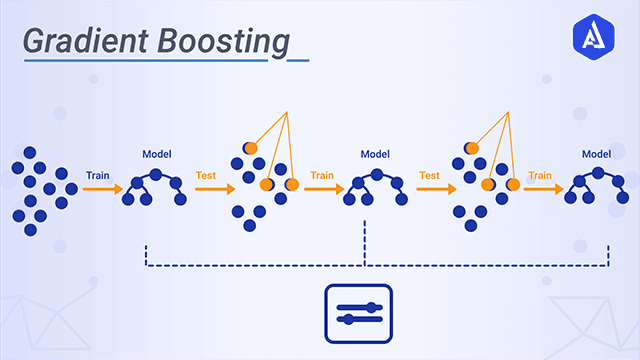

In [ ]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
                'loss' : ['ls'],
                'n_estimators' : [3], 
                'max_depth' : [9],
                'max_features' : ['auto'] 
             }

gbr = GradientBoostingRegressor()

model_gbr = sklearn.model_selection.GridSearchCV(estimator = gbr, n_jobs = -1, param_grid = param_grid)
model_gbr.fit(X_train1, y_train1)

y_pred = model_gbr.predict(X_test)
print("RMSE using GBR:", caculator_RMSE(X_train1, y_train1, model_gbr))

# **5. Kết quả**

XGBRegression có Private score là 0.47829

Gradient Boosting Regressor có Private score là 0.51091